In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import itertools
import os
import random
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = '../Mango/MangoLeafDataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
# Splitting data into train-test sets
from sklearn.model_selection import train_test_split

# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.75, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [4]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

#custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

nb_train_samples = train_gen.samples
nb_validation_samples = valid_gen.samples
nb_test_samples = test_gen.samples
classes = list(train_gen.class_indices.keys())
print('Classes: '+str(classes))

Found 3000 validated image filenames belonging to 8 classes.
Found 500 validated image filenames belonging to 8 classes.
Found 500 validated image filenames belonging to 8 classes.
Classes: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


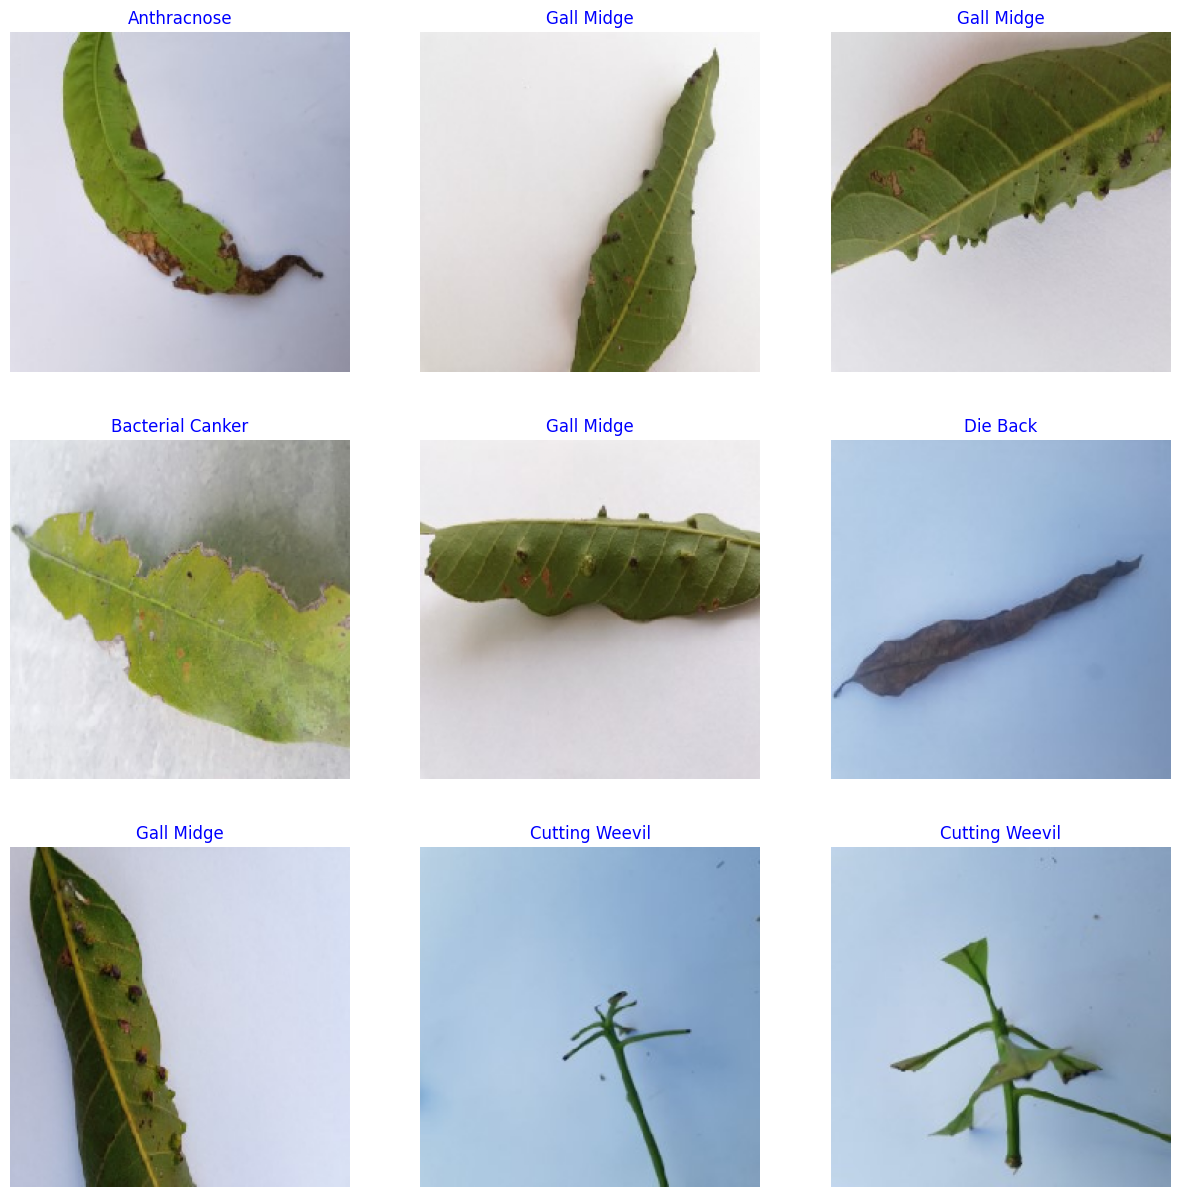

In [5]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(15, 15))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()


In [6]:
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = MobileNetV2(weights='imagenet',include_top=False, input_shape=img_shape)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax',kernel_initializer='random_uniform')
])

model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [7]:
epochs = 30   # number of all epochs in training

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='mobilenetv2.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/30
94/94 [==============================] - 10s 58ms/step - loss: 4.6747 - accuracy: 0.7713 - val_loss: 2.2404 - val_accuracy: 0.8720
Epoch 2/30
94/94 [==============================] - 4s 40ms/step - loss: 1.4661 - accuracy: 0.8987 - val_loss: 1.1459 - val_accuracy: 0.9060
Epoch 3/30
94/94 [==============================] - 4s 40ms/step - loss: 1.0194 - accuracy: 0.9130 - val_loss: 0.9344 - val_accuracy: 0.9120
Epoch 4/30
94/94 [==============================] - 4s 41ms/step - loss: 0.9176 - accuracy: 0.9170 - val_loss: 0.8859 - val_accuracy: 0.9080
Epoch 5/30
94/94 [==============================] - 4s 45ms/step - loss: 0.8867 - accuracy: 0.9170 - val_loss: 0.8759 - val_accuracy: 0.9060
Epoch 6/30
94/94 [==============================] - 4s 43ms/step - loss: 0.8415 - accuracy: 0.9270 - val_loss: 0.8107 - val_accuracy: 0.9260
Epoch 7/30
94/94 [==============================] - 4s 43ms/step - loss: 0.8254 - accuracy: 0.9243 - val_loss: 0.7722 - val_accuracy: 0.9240
Epoch 8/30
9

In [8]:
model.save('mobilenetv2.h5')

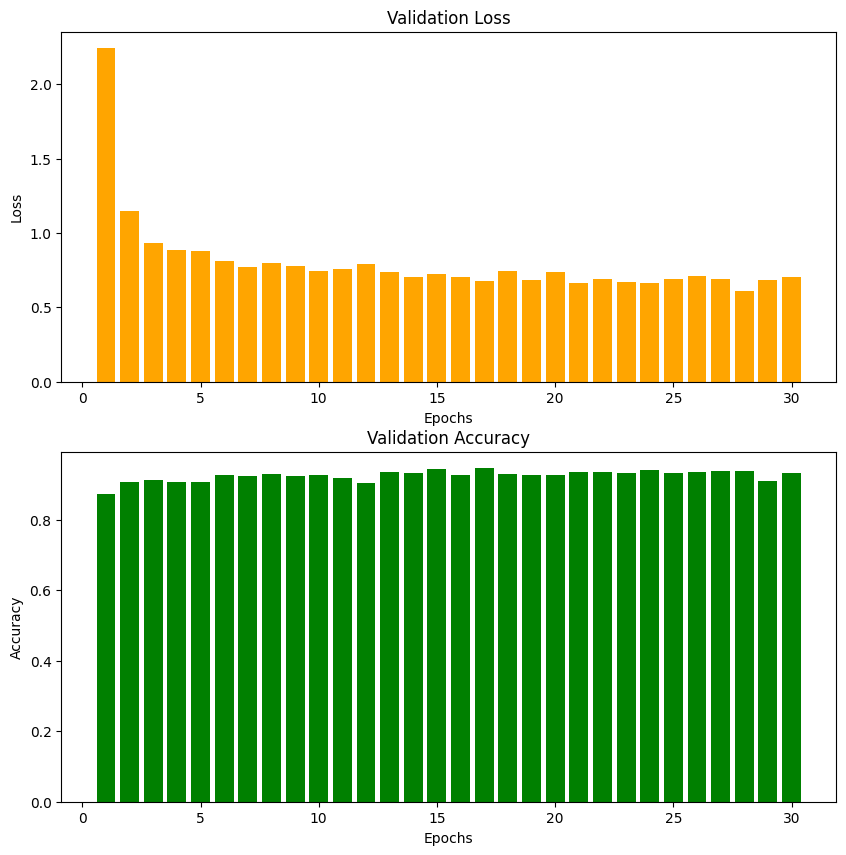

In [9]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)

plt.bar(epochs_x, val_loss_values,color='orange')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.bar(epochs_x, val_acc_values,color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

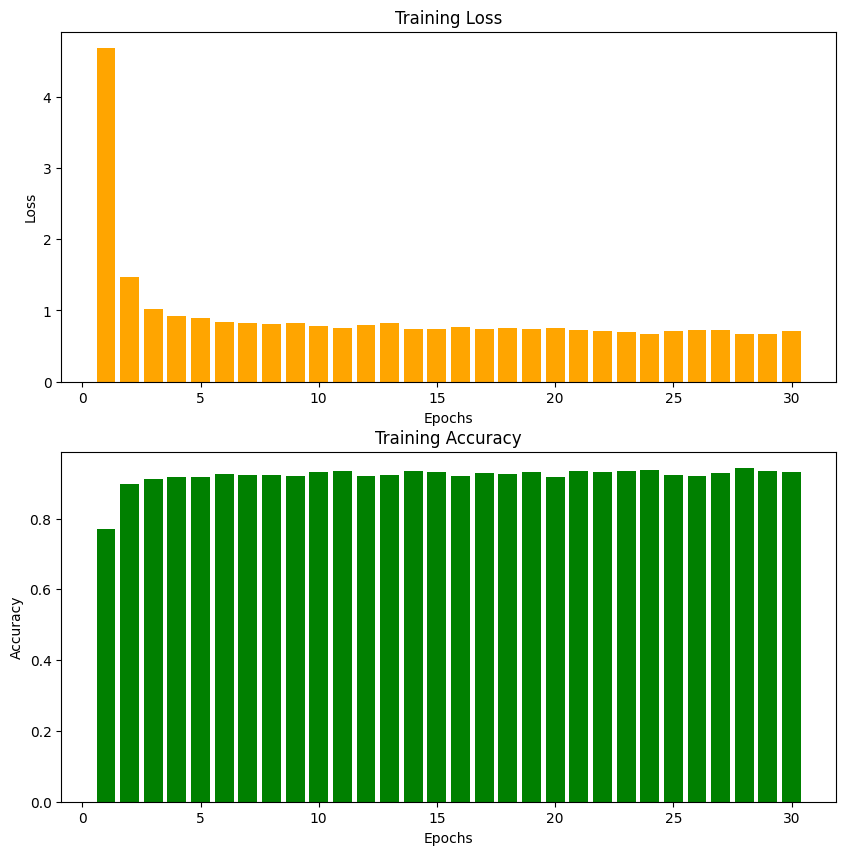

In [10]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)

plt.bar(epochs_x, loss_values,color='orange')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.bar(epochs_x, acc_values,color='green')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

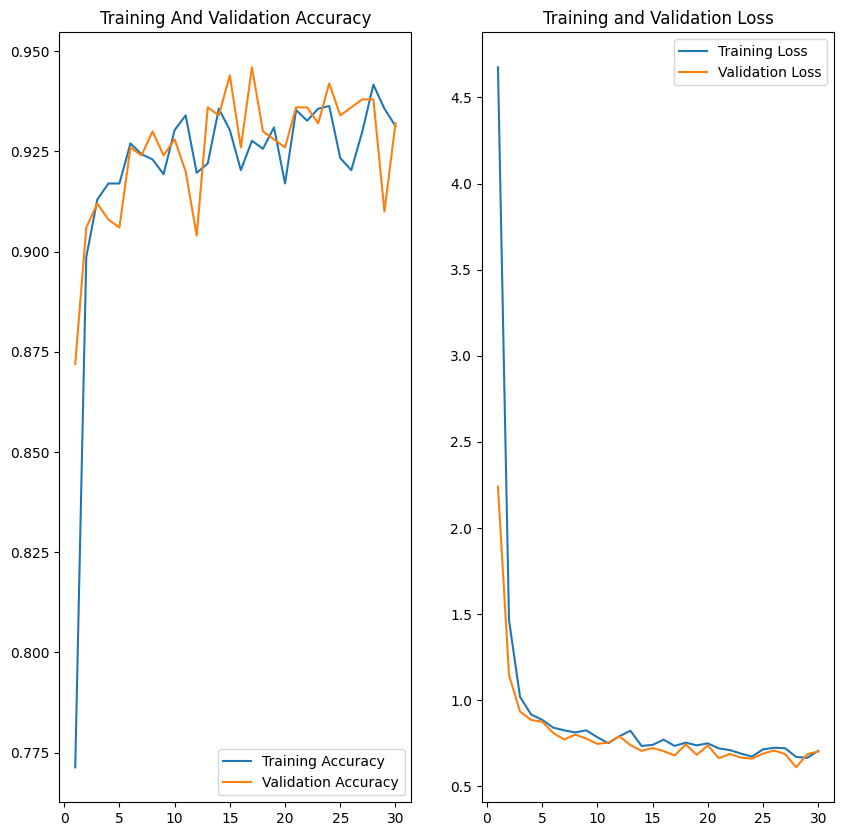

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_x, acc_values, label="Training Accuracy")
plt.plot(epochs_x, val_acc_values, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training And Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_x, loss_values, label="Training Loss")
plt.plot(epochs_x, val_loss_values, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [12]:
from tensorflow.keras.models import load_model
model = load_model('mobilenetv2.h5')


In [13]:
score = model.evaluate(valid_gen)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

16/16 [==============================] - 1s 41ms/step - loss: 0.7029 - accuracy: 0.9320
Val loss: 0.7029492855072021
Val accuracy: 0.9319999814033508


In [14]:
score = model.evaluate(test_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 1s 45ms/step - loss: 0.6991 - accuracy: 0.9320
Test loss: 0.6991168856620789
Test accuracy: 0.9319999814033508


In [15]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(16,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

10/10 [==============================] - 1s 44ms/step
Classification Report
                  precision    recall  f1-score   support

     Anthracnose       0.90      0.92      0.91        48
Bacterial Canker       0.91      0.97      0.94        72
  Cutting Weevil       0.99      1.00      0.99        73
        Die Back       1.00      0.97      0.98        59
      Gall Midge       0.86      0.89      0.88        64
         Healthy       0.95      0.95      0.95        56
  Powdery Mildew       0.98      0.88      0.93        68
     Sooty Mould       0.87      0.87      0.87        60

        accuracy                           0.93       500
       macro avg       0.93      0.93      0.93       500
    weighted avg       0.93      0.93      0.93       500



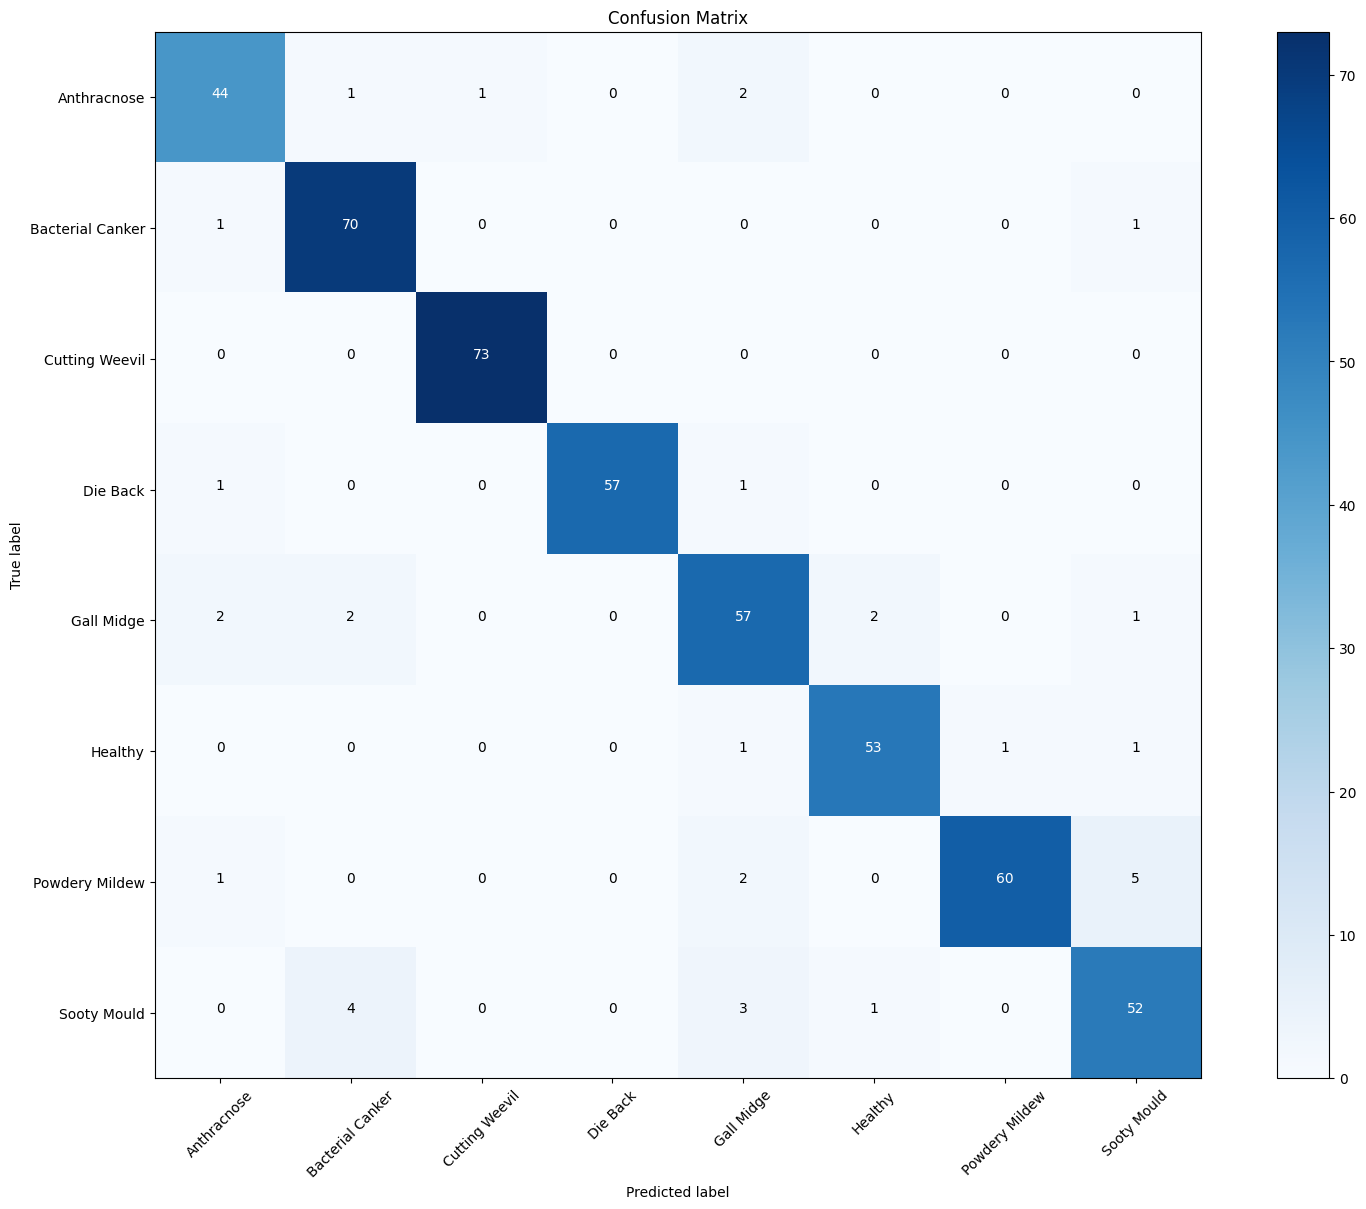

In [16]:
Y_pred = model.predict(test_gen)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Convert test_gen.classes to numpy array
test_labels = np.array(test_gen.classes)

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=target_names))


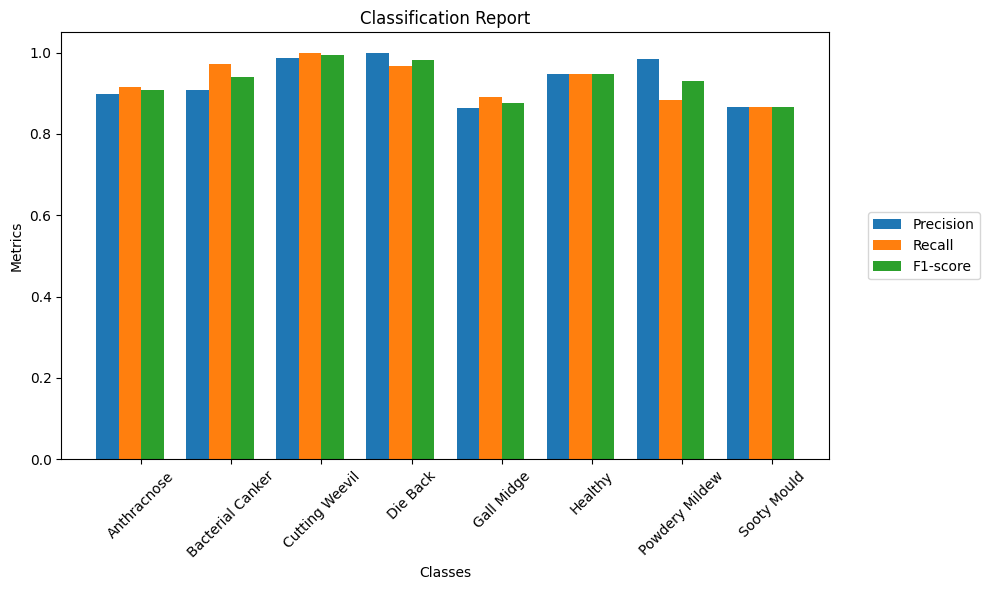

In [17]:
classification_rep = classification_report(test_gen.classes, y_pred, target_names=target_names, output_dict=True)
precision = [classification_rep[class_name]['precision'] for class_name in target_names]
recall = [classification_rep[class_name]['recall'] for class_name in target_names]
f1_score = [classification_rep[class_name]['f1-score'] for class_name in target_names]

# Plot the bar graph
plt.figure(figsize=(10, 6))
x = np.arange(len(target_names))
bar_width = 0.25

plt.bar(x, precision, width=bar_width, label='Precision')
plt.bar(x + bar_width, recall, width=bar_width, label='Recall')
plt.bar(x + 2 * bar_width, f1_score, width=bar_width, label='F1-score')

plt.xticks(x + 1.5 * bar_width, target_names, rotation=45)
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.title('Classification Report')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)  # Place legend outside the plot, vertically centered
plt.tight_layout()
plt.show()
